In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms

from utils import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

In [2]:
real_data_path = "../data/data.npy"
real_data = np.load(real_data_path)

ai_data_path = "../data/data_ai.npy"
ai_data = np.load(ai_data_path)

combined_data = np.concatenate([real_data, ai_data], axis = 0)

# we apply stratified sampling
X_train, X_test, y_train, y_test = train_test_split(combined_data[:,:-1], combined_data[:,-1], test_size=0.3, stratify=combined_data[:,-1])

In [15]:
# transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.85, 1.15)),
# transforms.RandomChoice([]),
# transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
# transforms.ColorJitter(brightness=0.15, contrast=0.14),

transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.95, 1.05)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
        transforms.Compose([
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
        ]),
        
    ]),
])

transform2 = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.95, 1.05)),
])

transform3 = transforms.Compose([
    transforms.RandomErasing(p=1,scale=(0.02,.2),ratio=(0.01,1))
])


data_transforms = [transform1,transforms]
train_data = DataLoader([X_train, y_train], shuffle=True, batch_size=16, shape=[128,128], device=DEVICE, transforms=data_transforms)
test_data = DataLoader([X_test, y_test], shape=[128,128], device=DEVICE)

real_data = DataLoader("../data/data.npy", shape=[128,128], device=DEVICE, transforms=data_transforms)
ai_data = DataLoader("../data/data_ai.npy", shape=[128,128], device=DEVICE, transforms=data_transforms)

In [16]:
train_data, test_data

(Data with shape of (272, 1, 128, 128), shuffle = True, batch_size = 16,
 Data with shape of (59, 1, 128, 128), shuffle = False, batch_size = 1)

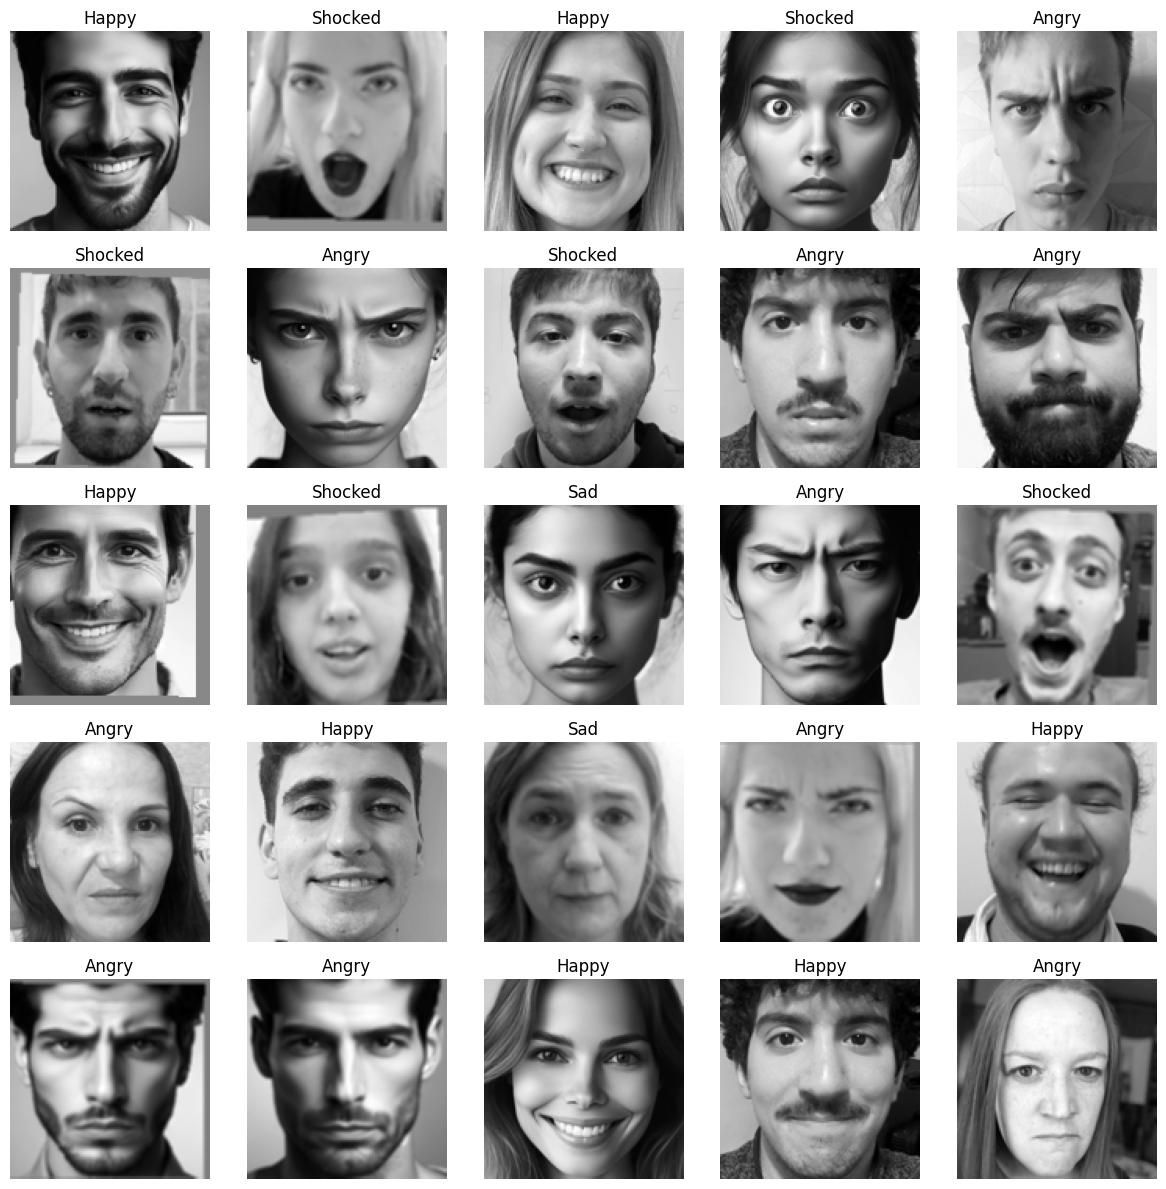

In [17]:
visualize(train_data, 5, 128)

In [18]:
# we had to keep it in different file so we can use it in live test folder 
from model import *

model = CNN128()
sum(p.numel() for p in model.parameters())

1052372

In [19]:
N, C, W, H = train_data.shape
N_test = test_data.size

n_epoch = 100

model = CNN128()
optimizer = optim.Adam(model.parameters(), lr = 3e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")

model.to(DEVICE)

losses = {"train": list(), "test": list()}

best_test_loss = float('inf')

for epoch in range(n_epoch):
    model.train()
    
    running_loss = .0
    for X_batch, y_batch in train_data:

        
        y_pred = model(X_batch.float())

        loss = criterion(y_pred, y_batch.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    running_loss /= N


    # test the model
    model.eval()
    predictions = model(test_data.X.to(DEVICE).float())
    pred_class = torch.argmax(predictions, axis = 1)
    test_acc = (pred_class == test_data.y.to(DEVICE)).float().mean()
    test_loss = criterion(predictions, test_data.y.to(DEVICE).long()).item() / N_test
    
    print(f"Epoch: {epoch+1:>2}, Train loss: \033[92m{running_loss:.4f}\033[0m, Test loss: \033[94m{test_loss:.4f}\033[0m, Test accuracy: {colorize_accuracy(test_acc)}{test_acc:.4f}\033[0m.")

    # save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), '../model/model_1')

    losses["train"].append(running_loss)
    losses["test"].append(test_loss)


# load the best model
model.load_state_dict(torch.load('../model/model_1'))


Epoch:  1, Train loss: 1.5149, Test loss: 1.3646, Test accuracy: 0.3220.
Epoch:  2, Train loss: 1.1393, Test loss: 1.2898, Test accuracy: 0.3898.
Epoch:  3, Train loss: 0.9136, Test loss: 1.0503, Test accuracy: 0.5763.
Epoch:  4, Train loss: 0.8091, Test loss: 0.9777, Test accuracy: 0.6102.
Epoch:  5, Train loss: 0.7477, Test loss: 0.8964, Test accuracy: 0.5763.
Epoch:  6, Train loss: 0.6865, Test loss: 0.8653, Test accuracy: 0.5763.
Epoch:  7, Train loss: 0.6337, Test loss: 0.9110, Test accuracy: 0.5763.
Epoch:  8, Train loss: 0.6384, Test loss: 0.8867, Test accuracy: 0.5932.
Epoch:  9, Train loss: 0.5377, Test loss: 0.8775, Test accuracy: 0.6102.
Epoch: 10, Train loss: 0.4912, Test loss: 0.8097, Test accuracy: 0.5593.
Epoch: 11, Train loss: 0.5249, Test loss: 0.8672, Test accuracy: 0.6610.
Epoch: 12, Train loss: 0.4699, Test loss: 0.8782, Test accuracy: 0.6271.
Epoch: 13, Train loss: 0.3947, Test loss: 0.9875, Test accuracy: 0.6271.
Epoch: 14, Train loss: 0.4445, Test loss: 0.8282, T

<All keys matched successfully>

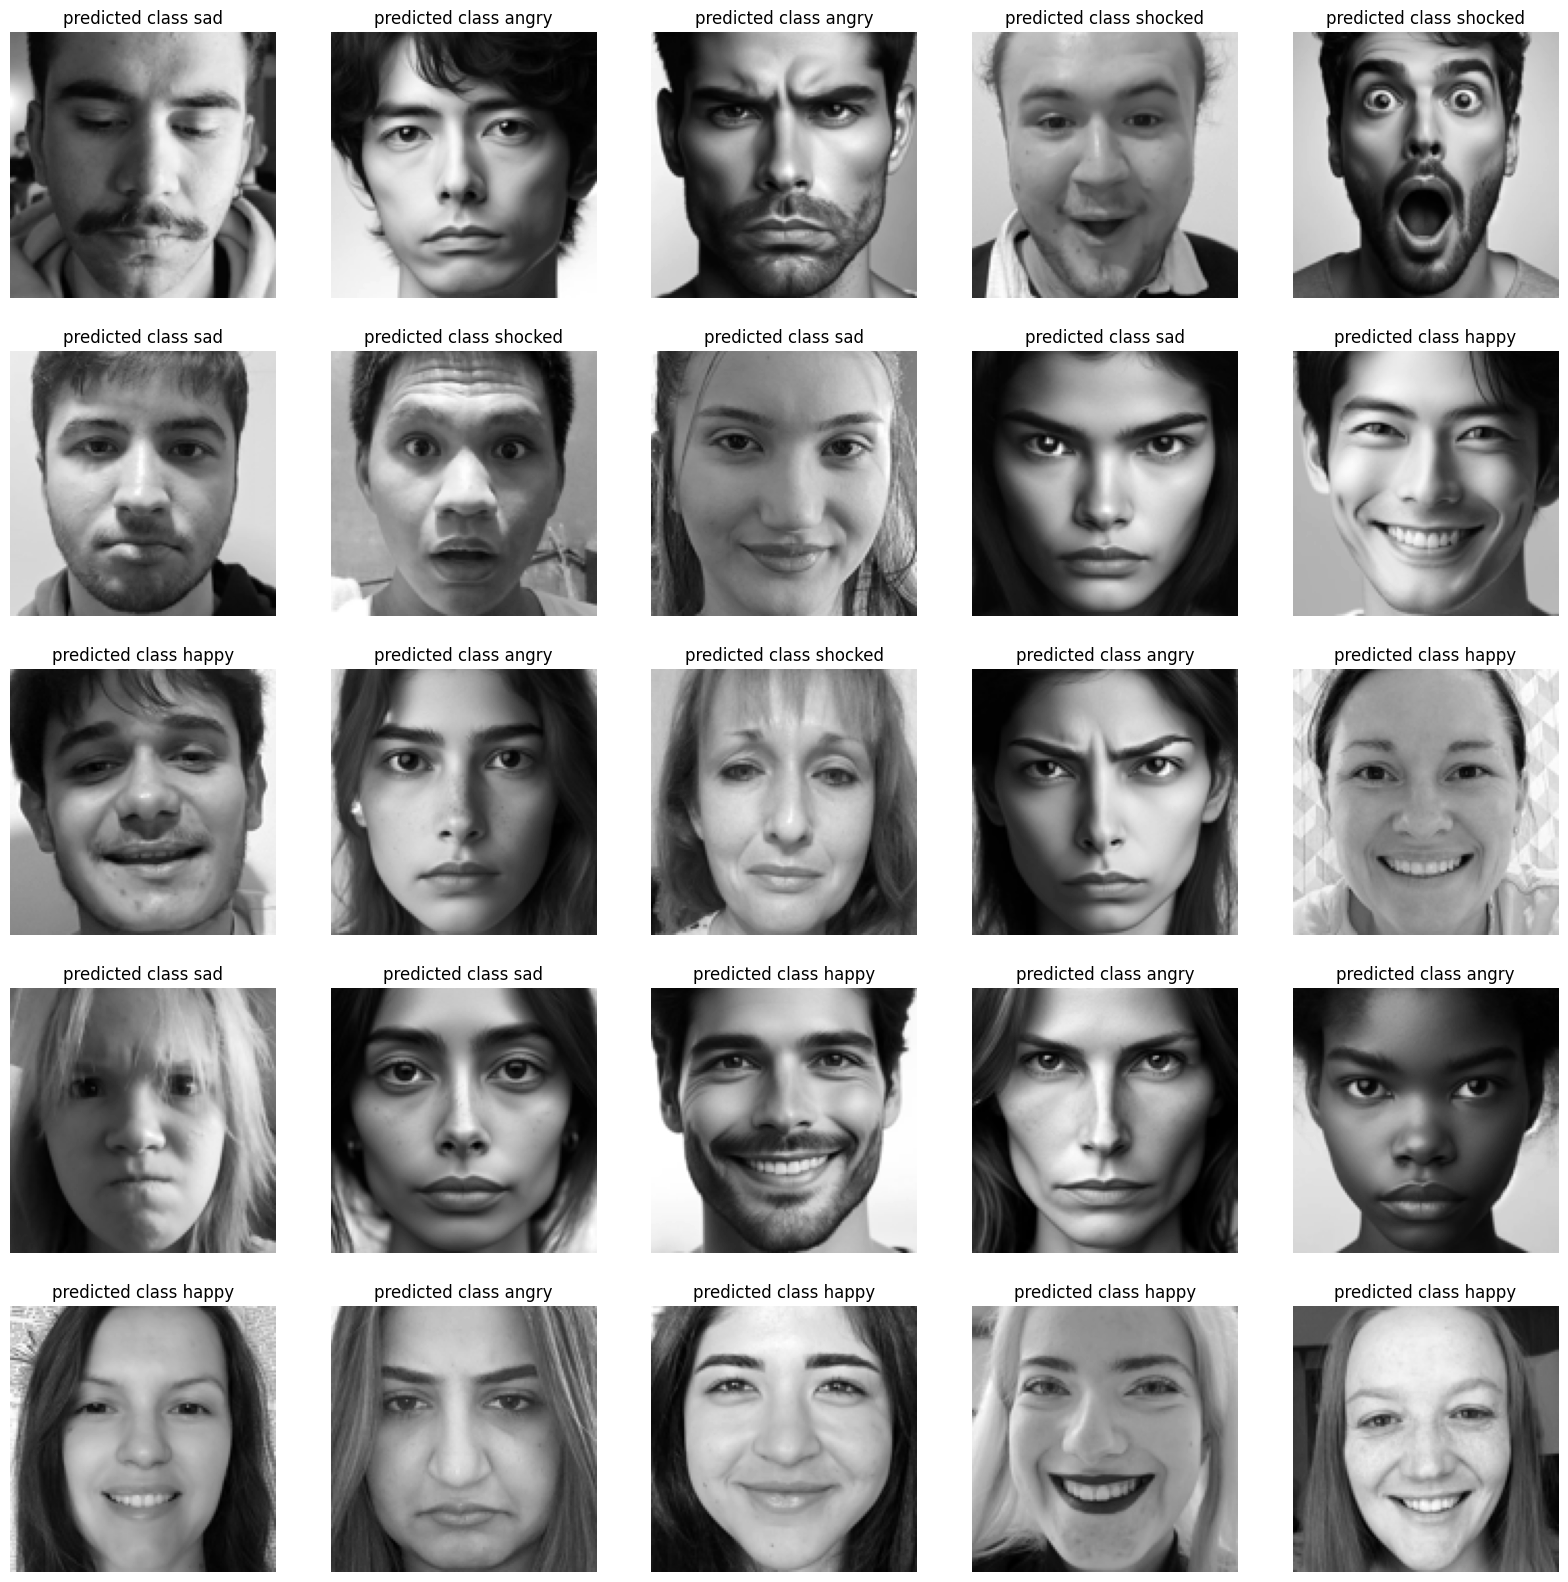

In [20]:
emotion_map = {0.:"angry", 1.:"happy", 2.:"sad", 3.:"shocked"}

predictions = model(test_data.X.to(DEVICE).float()).argmax(axis = 1)


fig, axs = plt.subplots(5, 5, figsize=(20, 20))

axs = axs.flatten()
# Loop through each image and plot it
for i in range(test_data.size):
    if i == 25:
        break
    axs[i].imshow(test_data.X[i].squeeze(), cmap='gray')  # Assuming grayscale images
    axs[i].axis('off')  # Turn off axis labels
    axs[i].set_title(f"predicted class {emotion_map[int(predictions[i])]}")  # Add a title for each subplot

plt.show()

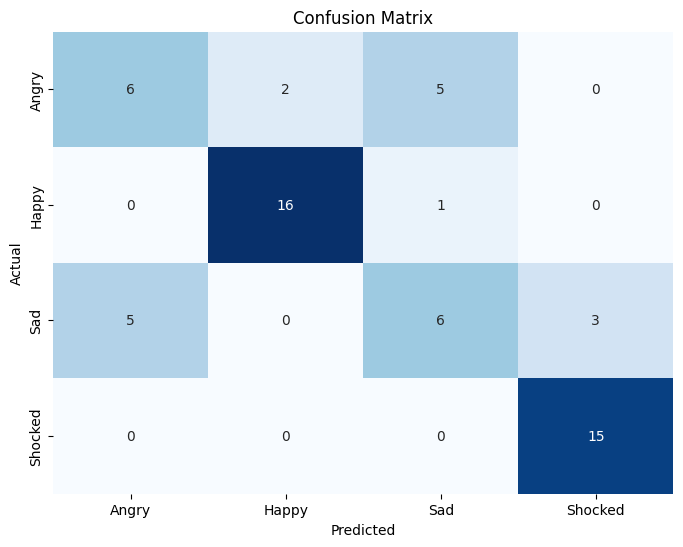

Loss: 0.6606, Accuracy = 0.7288


In [21]:
test_model(model, test_data, criterion, DEVICE)

In [10]:
# fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# axs = axs.flatten()
# # Loop through each image and plot it
# for i in range(train_data.size):
#     if i == 25:
#         break
#     axs[i].imshow(train_data.X[i].cpu().squeeze(), cmap='gray')  # Assuming grayscale images
#     axs[i].axis('off')  # Turn off axis labels

# plt.show()

In [11]:
# train_data.y.unique(return_counts=True), test_data.y.unique(return_counts=True)

In [22]:
torch.save(model.state_dict(), "../model/model")